In [1]:
import ROOT as rt
from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
from math import pow
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Welcome to JupyROOT 6.18/02
setGPU: Setting GPU to: 0


In [2]:
variables = ['fatJet1Pt', 'fatJet1Eta', 'fatJet1MassSD', 'fatJet2Pt', 'fatJet2Eta',# 'fatJet2MassSD', 'fatJet2PNetXbb',
             'hh_pt','hh_eta','hh_mass','MET','NJets','fatJet3Pt', 'fatJet3Eta', 'fatJet3MassSD', 
            #'fatJet1HasElectron','fatJet1HasMuon','fatJet2HasElectron','fatJet2HasMuon'
            ]
id_variables = ['run','lumi','event']
wt_variables = ['weight']
mass_variables= ['fatJet2MassSD']
QCD_bdt =['disc_qcd_and_ttbar_Run2_enhanced_v24']

# Load data

In [3]:
def convert(tree, target=0):
    feature = tree2array(tree,
                        branches = id_variables+wt_variables+variables+mass_variables+QCD_bdt ,
                        #branches = variables,
                         selection = 'disc_qcd_and_ttbar_Run2_enhanced_v24>0.028')
    if target == 0:
        label = np.zeros(shape = feature.shape, dtype=[('label','f4')])
    else:
        label = np.ones(shape = feature.shape, dtype=[('label','f4')])
    #data = nlr.merge_arrays([label,feature], flatten=True)
    #auxInfo = tree2array(tree,
    #                     branches = ['mass_jj','mass_gg'])
    return feature

In [4]:
#main_path ='/storage/user/sixie/data/HH/v1/SignalSelection/v1/2017/'
main_paths = []
main_paths.append('/storage/user/sixie/data/HH/HHTo4BNtupler/20200902/option5/combined/BDT/Jet2Xbb0p8Skim/2017/')
main_paths.append('/storage/user/sixie/data/HH/HHTo4BNtupler/20200902/option5/combined/BDT/Jet2Xbb0p8Skim/2016/')
main_paths.append('/storage/user/sixie/data/HH/HHTo4BNtupler/20200902/option5/combined/BDT/Jet2Xbb0p8Skim/2018/')
bkg_list =[]
sig_list=[]
bkg_list.append('WminusH')
bkg_list.append('WplusH')
bkg_list.append('ZH')
bkg_list.append('ttH')
sig_list.append('GluGluToHHTo4B_node_cHHH0')

bkg_file =[]
sig_file =[]

for main_path in main_paths:
    
    directory = os.listdir(main_path)
    for name in directory:
        #print(name)
        for bkg_i in bkg_list:
            if (main_path+bkg_i) in (main_path+name):
                #print(main_path+name)
                bkg_file.append(rt.TFile.Open(str(main_path+name)))
        for sig_i in sig_list:
            if (main_path+sig_i) in (main_path+name):
                #print(main_path+name)
                sig_file.append(rt.TFile.Open(main_path+name))
from numpy.lib.recfunctions import append_fields
bkg_frame = []
for file in bkg_file:
    print(file)
    bkgtree = file.Get("tree")
    bkgnp = convert(bkgtree, 0)
    bkg_frame.append(pd.DataFrame.from_records(bkgnp))
sig_frame=[]    
for file in sig_file:
    print(file)
    sigtree = file.Get("tree")
    signp = convert(sigtree, 1)
    sig_frame.append(pd.DataFrame.from_records(signp))

for i in range(len(sig_frame)):
    sig_frame[i]['NJets'] = sig_frame[i]['NJets']+1
    sig_frame[i]["fatJet3Eta"] = np.abs(sig_frame[i]["fatJet3Eta"])
    sig_frame[i].loc[sig_frame[i]["fatJet3Pt"] == 0, "fatJet3Eta"] = -1
    #sig_frame[i].loc[sig_frame[i]["fatJet3Pt"] == 0, "fatJet3Tau3OverTau2"] = -1
for i in range(len(bkg_frame)):
    bkg_frame[i]['NJets'] = bkg_frame[i]['NJets']+1
    bkg_frame[i]["fatJet3Eta"] = np.abs(bkg_frame[i]["fatJet3Eta"])
    bkg_frame[i].loc[bkg_frame[i]["fatJet3Pt"] == 0, "fatJet3Eta"] = -1
    #bkg_frame[i].loc[bkg_frame[i]["fatJet3Pt"] == 0, "fatJet3Tau3OverTau2"] = -1


Name: /storage/user/sixie/data/HH/HHTo4BNtupler/20200902/option5/combined/BDT/Jet2Xbb0p8Skim/2017/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8_1pb_weighted_BDTs_Jet2Xbb0p8Skim.root Title: 
Name: /storage/user/sixie/data/HH/HHTo4BNtupler/20200902/option5/combined/BDT/Jet2Xbb0p8Skim/2017/ZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8_1pb_weighted_BDTs_Jet2Xbb0p8Skim.root Title: 
Name: /storage/user/sixie/data/HH/HHTo4BNtupler/20200902/option5/combined/BDT/Jet2Xbb0p8Skim/2017/WminusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8_1pb_weighted_BDTs_Jet2Xbb0p8Skim.root Title: 
Name: /storage/user/sixie/data/HH/HHTo4BNtupler/20200902/option5/combined/BDT/Jet2Xbb0p8Skim/2017/WplusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8_1pb_weighted_BDTs_Jet2Xbb0p8Skim.root Title: 
Name: /storage/user/sixie/data/HH/HHTo4BNtupler/20200902/option5/combined/BDT/Jet2Xbb0p8Skim/2016/ttHTobb_M125_13TeV_powheg_pythia8_1pb_weighted_BDTs_Jet2Xbb0p8Skim.root Title: 
Name: /storage/user/sixie/data/HH/HHTo4BNtupler/20200902/option5/combine

In [5]:
sig_frame[0].head()

,run,lumi,event,weight,fatJet1Pt,fatJet1Eta,fatJet1MassSD,fatJet2Pt,fatJet2Eta,hh_pt,hh_eta,hh_mass,MET,NJets,fatJet3Pt,fatJet3Eta,fatJet3MassSD,fatJet2MassSD,disc_qcd_and_ttbar_Run2_enhanced_v24
0,1,718,71727,2.511764e-08,432.50,-1.614014,133.250,367.75,-1.791992,65.901230,-4.162527,832.836731,18.837618,0,0.00,-1.000000,0.000000,92.1250,0.075466
1,1,757,75696,2.511764e-08,427.00,0.201691,120.375,427.00,-0.490662,44.450924,-1.803841,933.711487,38.381920,1,0.00,-1.000000,0.000000,110.0625,0.047811
2,1,1943,194229,2.511764e-08,398.00,0.925415,131.750,312.75,1.112549,206.859360,2.117957,738.085083,67.408028,3,0.00,-1.000000,0.000000,146.2500,0.098711
3,1,2205,220472,2.511764e-08,414.50,-0.898926,124.750,505.00,-0.946167,268.046417,-2.004999,915.257263,44.883102,3,0.00,-1.000000,0.000000,125.9375,0.068709
4,1,2215,221454,-2.511764e-08,333.25,1.637695,120.625,324.50,1.416748,136.183441,3.063629,697.178528,25.505196,3,241.75,1.295654,26.203125,134.1250,0.034376


## Check variables used in training before standardization

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


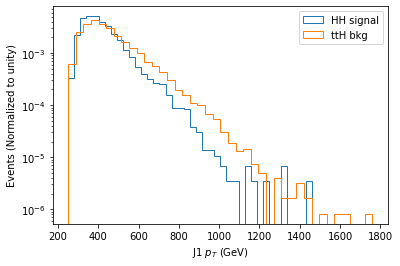

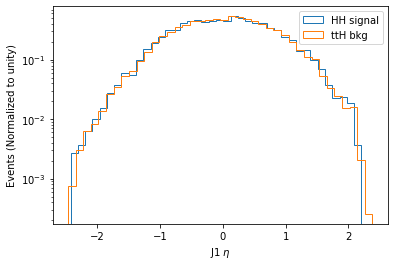

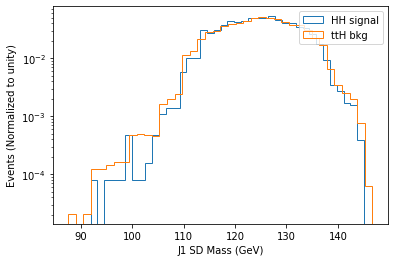

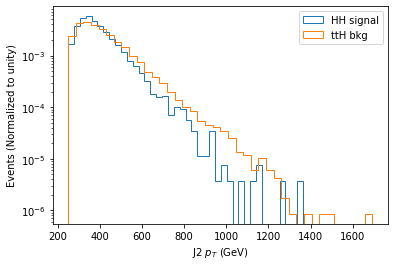

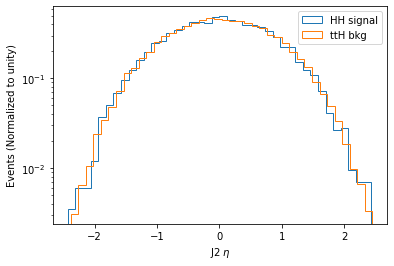

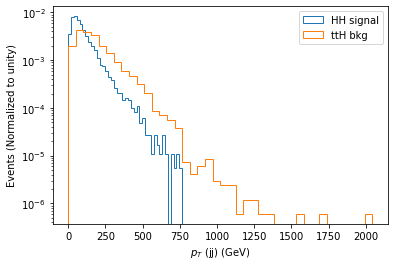

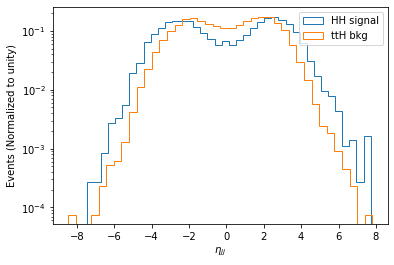

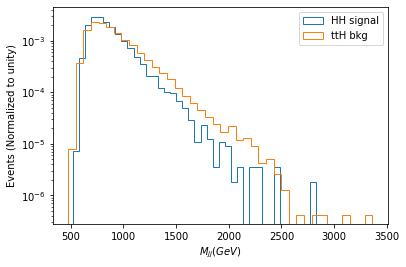

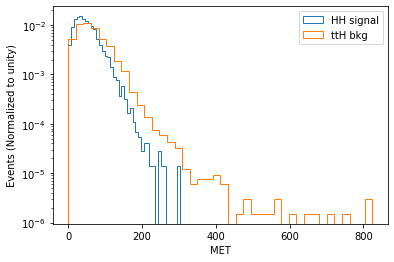

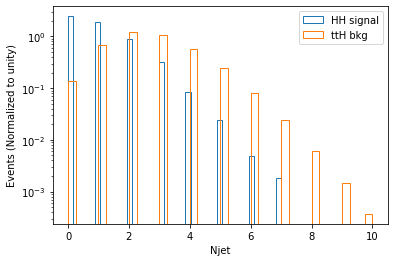

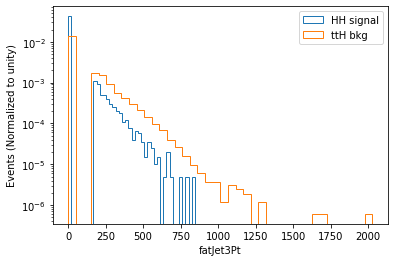

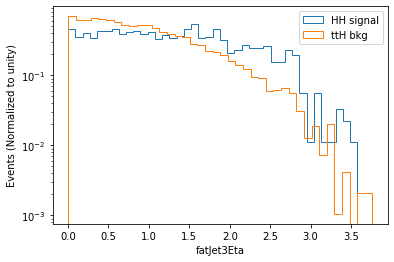

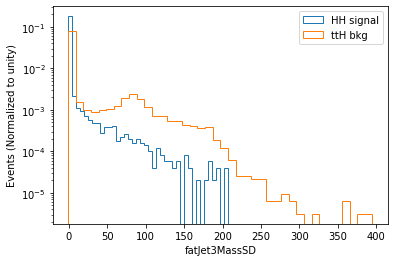

In [6]:
bkg_frame_VH = [bkg_frame[2],bkg_frame[1],bkg_frame[3],bkg_frame[5],bkg_frame[6],bkg_frame[7],bkg_frame[10],bkg_frame[9],bkg_frame[11]]
sig_full_frame = pd.concat(sig_frame)
background_VH_frame = pd.concat(bkg_frame_VH)
bkg_frame_ttH = [bkg_frame[0],bkg_frame[4],bkg_frame[8]]
background_ttH_frame = pd.concat(bkg_frame_ttH)
#although mass is plotted, it's not given to the training
#HLF = ['softJet5','dRmm','dEtamm','dPhimm','M_jj','pt_jj','eta_jj','phi_jj','M_mmjj','eta_mmjj','phi_mmjj','dEta_jj','Zep','dRmin_mj', 'dRmax_mj','dRmin_mmj','dRmax_mmj',
#        'leadingJet_pt','subleadingJet_pt','leadingJet_eta','subleadingJet_eta','leadingJet_qgl','subleadingJet_qgl','cthetaCS','Higgs_pt',
#        'Higgs_eta','Higgs_mass']
xlabel_HLF= ['J1 $p_{T}$ (GeV)','J1 $\eta$','J1 SD Mass (GeV)','J2 $p_{T}$ (GeV)','J2 $\eta$','$p_{T}$ (jj) (GeV)','$\eta_{jj}$','$M_{jj} (GeV)$', 'MET','Njet',
           'fatJet3Pt', 'fatJet3Eta', 'fatJet3MassSD', 
             #'fatJet1HasElectron','fatJet1HasMuon','fatJet2HasElectron','fatJet2HasMuon'
            ]
for hlf,xlabel_hlf in zip(variables,xlabel_HLF):
    plt.figure()
    #print(hlf,np.sum(sig_frame[hlf]))
    #print(hlf,np.sum(bkg_frame[hlf]))
    if hlf in ['fatJet3Eta','fatJet3PNetXbb','fatJet3Tau3OverTau2']:
        plt.hist(sig_full_frame[hlf][sig_full_frame[hlf]>0.], bins=40, normed=True, histtype='step', label='HH signal')
        #plt.hist(background_VH_frame[hlf][background_VH_frame[hlf]>0.], bins=40, normed=True, histtype='step', label='VH bkg')
        plt.hist(background_ttH_frame[hlf][background_ttH_frame[hlf]>0.], bins=40, normed=True, histtype='step', label='ttH bkg')
    else:
        plt.hist(sig_full_frame[hlf], bins=40, normed=True, histtype='step', label='HH signal')
        #plt.hist(background_VH_frame[hlf], bins=40, normed=True, histtype='step', label='VH bkg')
        plt.hist(background_ttH_frame[hlf], bins=40, normed=True, histtype='step', label='ttH bkg')
    plt.xlabel(xlabel_hlf)
    plt.ylabel('Events (Normalized to unity)')
    plt.legend(loc='best')
    plt.yscale('log')
    plt.savefig("Higgs_plots/SigBkgCompare_"+hlf+".png")

## Shuffle signal and background events

In [7]:
bkg_frame_VH = [bkg_frame[2],bkg_frame[1],bkg_frame[3],bkg_frame[5],bkg_frame[6],bkg_frame[7],bkg_frame[10],bkg_frame[9],bkg_frame[11]]
sig_full_frame = pd.concat(sig_frame)
background_VH_frame = pd.concat(bkg_frame_VH)

bkg_frame_ttH = [bkg_frame[0],bkg_frame[4],bkg_frame[8]]
background_ttH_frame = pd.concat(bkg_frame_ttH)

var_indices = [sig_full_frame.columns.get_loc(v) for v in variables] # get positions of all the variables set above
id_var_indices = [sig_full_frame.columns.get_loc(v) for v in id_variables]
wt_var_indices = [sig_full_frame.columns.get_loc(v) for v in wt_variables]
mass_var_indices = [sig_full_frame.columns.get_loc(v) for v in mass_variables]

#look for any NaN values
sig_full_frame = sig_full_frame.dropna()
#print(sig_full_frame.isnull().any())
signal = sig_full_frame.values


background_ttH_frame = background_ttH_frame.dropna()
#print(background_ttH_frame.isnull().any())
background_ttH = background_ttH_frame.values

#print(signal,background_ttH)
print("length of Signal :",len(sig_full_frame.values))
print("length of background VH:",len(background_VH_frame.values))
print("length of background ttH:",len(background_ttH_frame.values))



signal_wt = signal[:,wt_var_indices]
bkg_wt_ttH = background_ttH[:,wt_var_indices]

print(signal_wt)
print("sum of weights for signal before scaling: " )
print(np.sum(signal_wt))
print("sum of weights for bkg before scaling: " )
print(np.sum(bkg_wt_ttH))

sig_scale= np.sum(bkg_wt_ttH)/np.sum(signal_wt)
signal[:,wt_var_indices] = np.multiply(signal_wt, sig_scale)
signal_wt = signal[:,wt_var_indices]
bkg_wt_ttH = background_ttH[:,wt_var_indices]

print("sum of weights for signal after scaling: " )
print(np.sum(signal_wt))

print("sum of weights for ttH bkg after scaling: " )
print(np.sum(bkg_wt_ttH))

randix4 = np.arange(len(background_ttH))
np.random.shuffle(randix4)
background_ttH_ = background_ttH[randix4]

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]


sig_label = np.ones(len(signal_))
bkg_ttH_label = np.zeros(len(background_ttH_))

print(len(signal_))
print(len(background_ttH_))
data = np.concatenate((signal_,background_ttH_))
label = np.concatenate((sig_label,bkg_ttH_label))

randix3 = np.arange(len(data))
np.random.shuffle(randix3)
data= data[randix3,...]
label = label[randix3,...]

print(data.shape)
print(label.shape)


length of Signal : 9554
length of background VH: 1085
length of background ttH: 32433
[[2.51176395e-08]
 [2.51176395e-08]
 [2.51176395e-08]
 ...
 [2.53553996e-08]
 [2.53553996e-08]
 [2.53553996e-08]]
sum of weights for signal before scaling: 
0.0001938998302044581
sum of weights for bkg before scaling: 
0.0012590281660322944
sum of weights for signal after scaling: 
0.0012590281660322944
sum of weights for ttH bkg after scaling: 
0.0012590281660322944
9554
32433
(41987, 19)
(41987,)


In [8]:
background_ttH_frame.head()

,run,lumi,event,weight,fatJet1Pt,fatJet1Eta,fatJet1MassSD,fatJet2Pt,fatJet2Eta,hh_pt,hh_eta,hh_mass,MET,NJets,fatJet3Pt,fatJet3Eta,fatJet3MassSD,fatJet2MassSD,disc_qcd_and_ttbar_Run2_enhanced_v24
0,1,275,265509,3.770042e-08,358.50,-0.463318,117.7500,422.00,-0.588989,142.664825,-1.834477,811.412842,65.102341,1,0.00,-1.000000,0.0000,141.375,0.049923
1,1,276,266604,3.770042e-08,636.00,0.351685,125.8750,431.25,0.689575,206.570389,1.705660,1121.144653,217.638702,0,0.00,-1.000000,0.0000,212.375,0.045016
2,1,277,267623,3.770042e-08,455.00,0.765381,119.4375,430.00,0.073563,262.725159,1.237957,933.269958,11.425735,2,266.25,0.019253,73.4375,121.000,0.056718
3,1,277,267729,3.770042e-08,309.50,-0.916626,126.6875,314.50,-0.591064,29.693651,-3.560746,667.721741,52.381088,2,0.00,-1.000000,0.0000,89.375,0.047843
4,1,278,268414,3.770042e-08,385.75,1.047852,133.6250,399.00,0.750732,92.993927,2.861944,832.147339,65.452950,1,0.00,-1.000000,0.0000,133.000,0.032929


In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation,Dropout, Input, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [10]:
#def DNN_ROC(fpr_keras,tpr_keras,auc_keras,fpr_keras_tmp,tpr_keras_tmp,auc_keras_tmp) :
def DNN_ROC(fpr_keras,tpr_keras,fpr_keras_tmp,tpr_keras_tmp) :
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    #plt.plot(fpr_keras, tpr_keras, label='Keras Test (area = {:.3f})'.format(auc_keras))
    #plt.plot(fpr_keras_tmp, tpr_keras_tmp, label='Keras Train (area = {:.3f})'.format(auc_keras_tmp))
    plt.plot(fpr_keras, tpr_keras, label='Keras Test ')
    plt.plot(fpr_keras_tmp, tpr_keras_tmp, label='Keras Train ')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.05)
    #plt.ylim(0.8, 1) 
    plt.plot([0, 1], [0, 1], 'k--')
    #plt.plot(fpr_keras, tpr_keras, label='Keras Test (area = {:.3f})'.format(auc_keras))
    #plt.plot(fpr_keras_tmp, tpr_keras_tmp, label='Keras Train (area = {:.3f})'.format(auc_keras_tmp))
    plt.plot(fpr_keras, tpr_keras, label='Keras Test ')
    plt.plot(fpr_keras_tmp, tpr_keras_tmp, label='Keras Train ')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.show()

In [11]:
#def Combined_ROC(fpr_keras,tpr_keras,auc_keras,fpr_bdt, tpr_bdt,area_bdt):
def Combined_ROC(fpr_keras,tpr_keras,fpr_bdt, tpr_bdt):
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    #plt.plot(fpr_keras, tpr_keras, label='DNN (area = {:.3f})'.format(auc_keras),color='b')
    plt.plot(fpr_keras, tpr_keras, label='DNN ',color='b')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    #plt.legend(loc='best')
    #plt.show()
    #plt.figure(figsize=(9,7))
    #plt.plot(fpr_bdt,tpr_bdt,label="BDT (area ={:.3f})".format(area_bdt),color='r')
    plt.plot(fpr_bdt,tpr_bdt,label="BDT",color='r')
    #plt.xlim(0, 0.05)
    #plt.ylim(0.8, 1) 
    plt.legend(loc='best')
    plt.show()
    #plt.xlabel('Background contamination')
    #plt.ylabel('Signal efficiency')

In [12]:
def Combined_ROC_v2(fpr_keras,tpr_keras,fpr_bdt, tpr_bdt,fpr_ucsdbdt, tpr_ucsdbdt):
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    #plt.plot(fpr_keras, tpr_keras, label='DNN (area = {:.3f})'.format(auc_keras),color='b')
    plt.plot(fpr_keras, tpr_keras, label='DNN ',color='b')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    #plt.legend(loc='best')
    #plt.show()
    #plt.figure(figsize=(9,7))
    #plt.plot(fpr_bdt,tpr_bdt,label="BDT (area ={:.3f})".format(area_bdt),color='r')
    plt.plot(fpr_bdt,tpr_bdt,label="old DNN",color='r')
    plt.plot(fpr_ucsdbdt,tpr_ucsdbdt,label="UCSD BDT",color='g')
    plt.xlim(0, 0.05)
    
    #plt.ylim(0.8, 1) 
    plt.legend(loc='best')
    plt.show()
    #plt.xlabel('Background contamination')
    #plt.ylabel('Signal efficiency')

In [13]:
def score_classifier(y_test,y_pred, caption):
    ##########################################################
    # make histogram of discriminator value for signal and bkg
    ##########################################################
    yNN_frame = pd.DataFrame({'truth':y_test, 'disc_Z+jets':y_pred})
    disc_bkg    = yNN_frame[yNN_frame['truth'] == 0]['disc_Z+jets'].values
    disc_signal = yNN_frame[yNN_frame['truth'] == 1]['disc_Z+jets'].values
    plt.figure()
    plt.hist(disc_bkg, label='Bkg', normed=True, bins=50, alpha=0.3)
    plt.hist(disc_signal, label='Signal', normed=True, bins=50, alpha=0.3)
    plt.xlabel(caption)
    plt.yscale("log")
    plt.legend(prop={'size': 10})
    plt.legend(loc='best')
    plt.show()

In [14]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    #plt.ylim(bottom=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Error by Epoch')
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)


    plt.legend()
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(loc='lower right')
    plt.show()

In [15]:
def make_model(opt='adam', b_norm = False, n_hidden = 1, hidden= 100, do = 0.2):
    i = Input((13,), name='features')
    di = i
    for h in range(n_hidden):
        d = Dense(hidden, name='hidden_%d'%h, activation='tanh')(di)
        if do:
            d = Dropout(do)(d)
        if b_norm:
            d = BatchNormalization()(d)
        di = d
    o = Dense(1, name='categorization', activation='sigmoid')(d)
    model = Model(i,o)
    model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])
    model.summary()
    return model

In [16]:
def fit_model(model,x_train_reduced,y_train, x_train_wt,batch_size = 20, val_split=0.2):
    hist = model.fit(x_train_reduced, y_train, sample_weight= x_train_wt,batch_size=batch_size, nb_epoch=500,verbose=0,validation_split=val_split,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='model.h5', verbose=0)])
    return hist

## Separate into train and test events (60 %-40 % split)

(16787,)
(16787,)
[17]
(13,) (13,)
(25200, 13)
3806.0
16787
0.002518056332064589
(25200, 13) (16787, 13)
(25200,) (16787,)
5748.0 3806.0
(25200,)


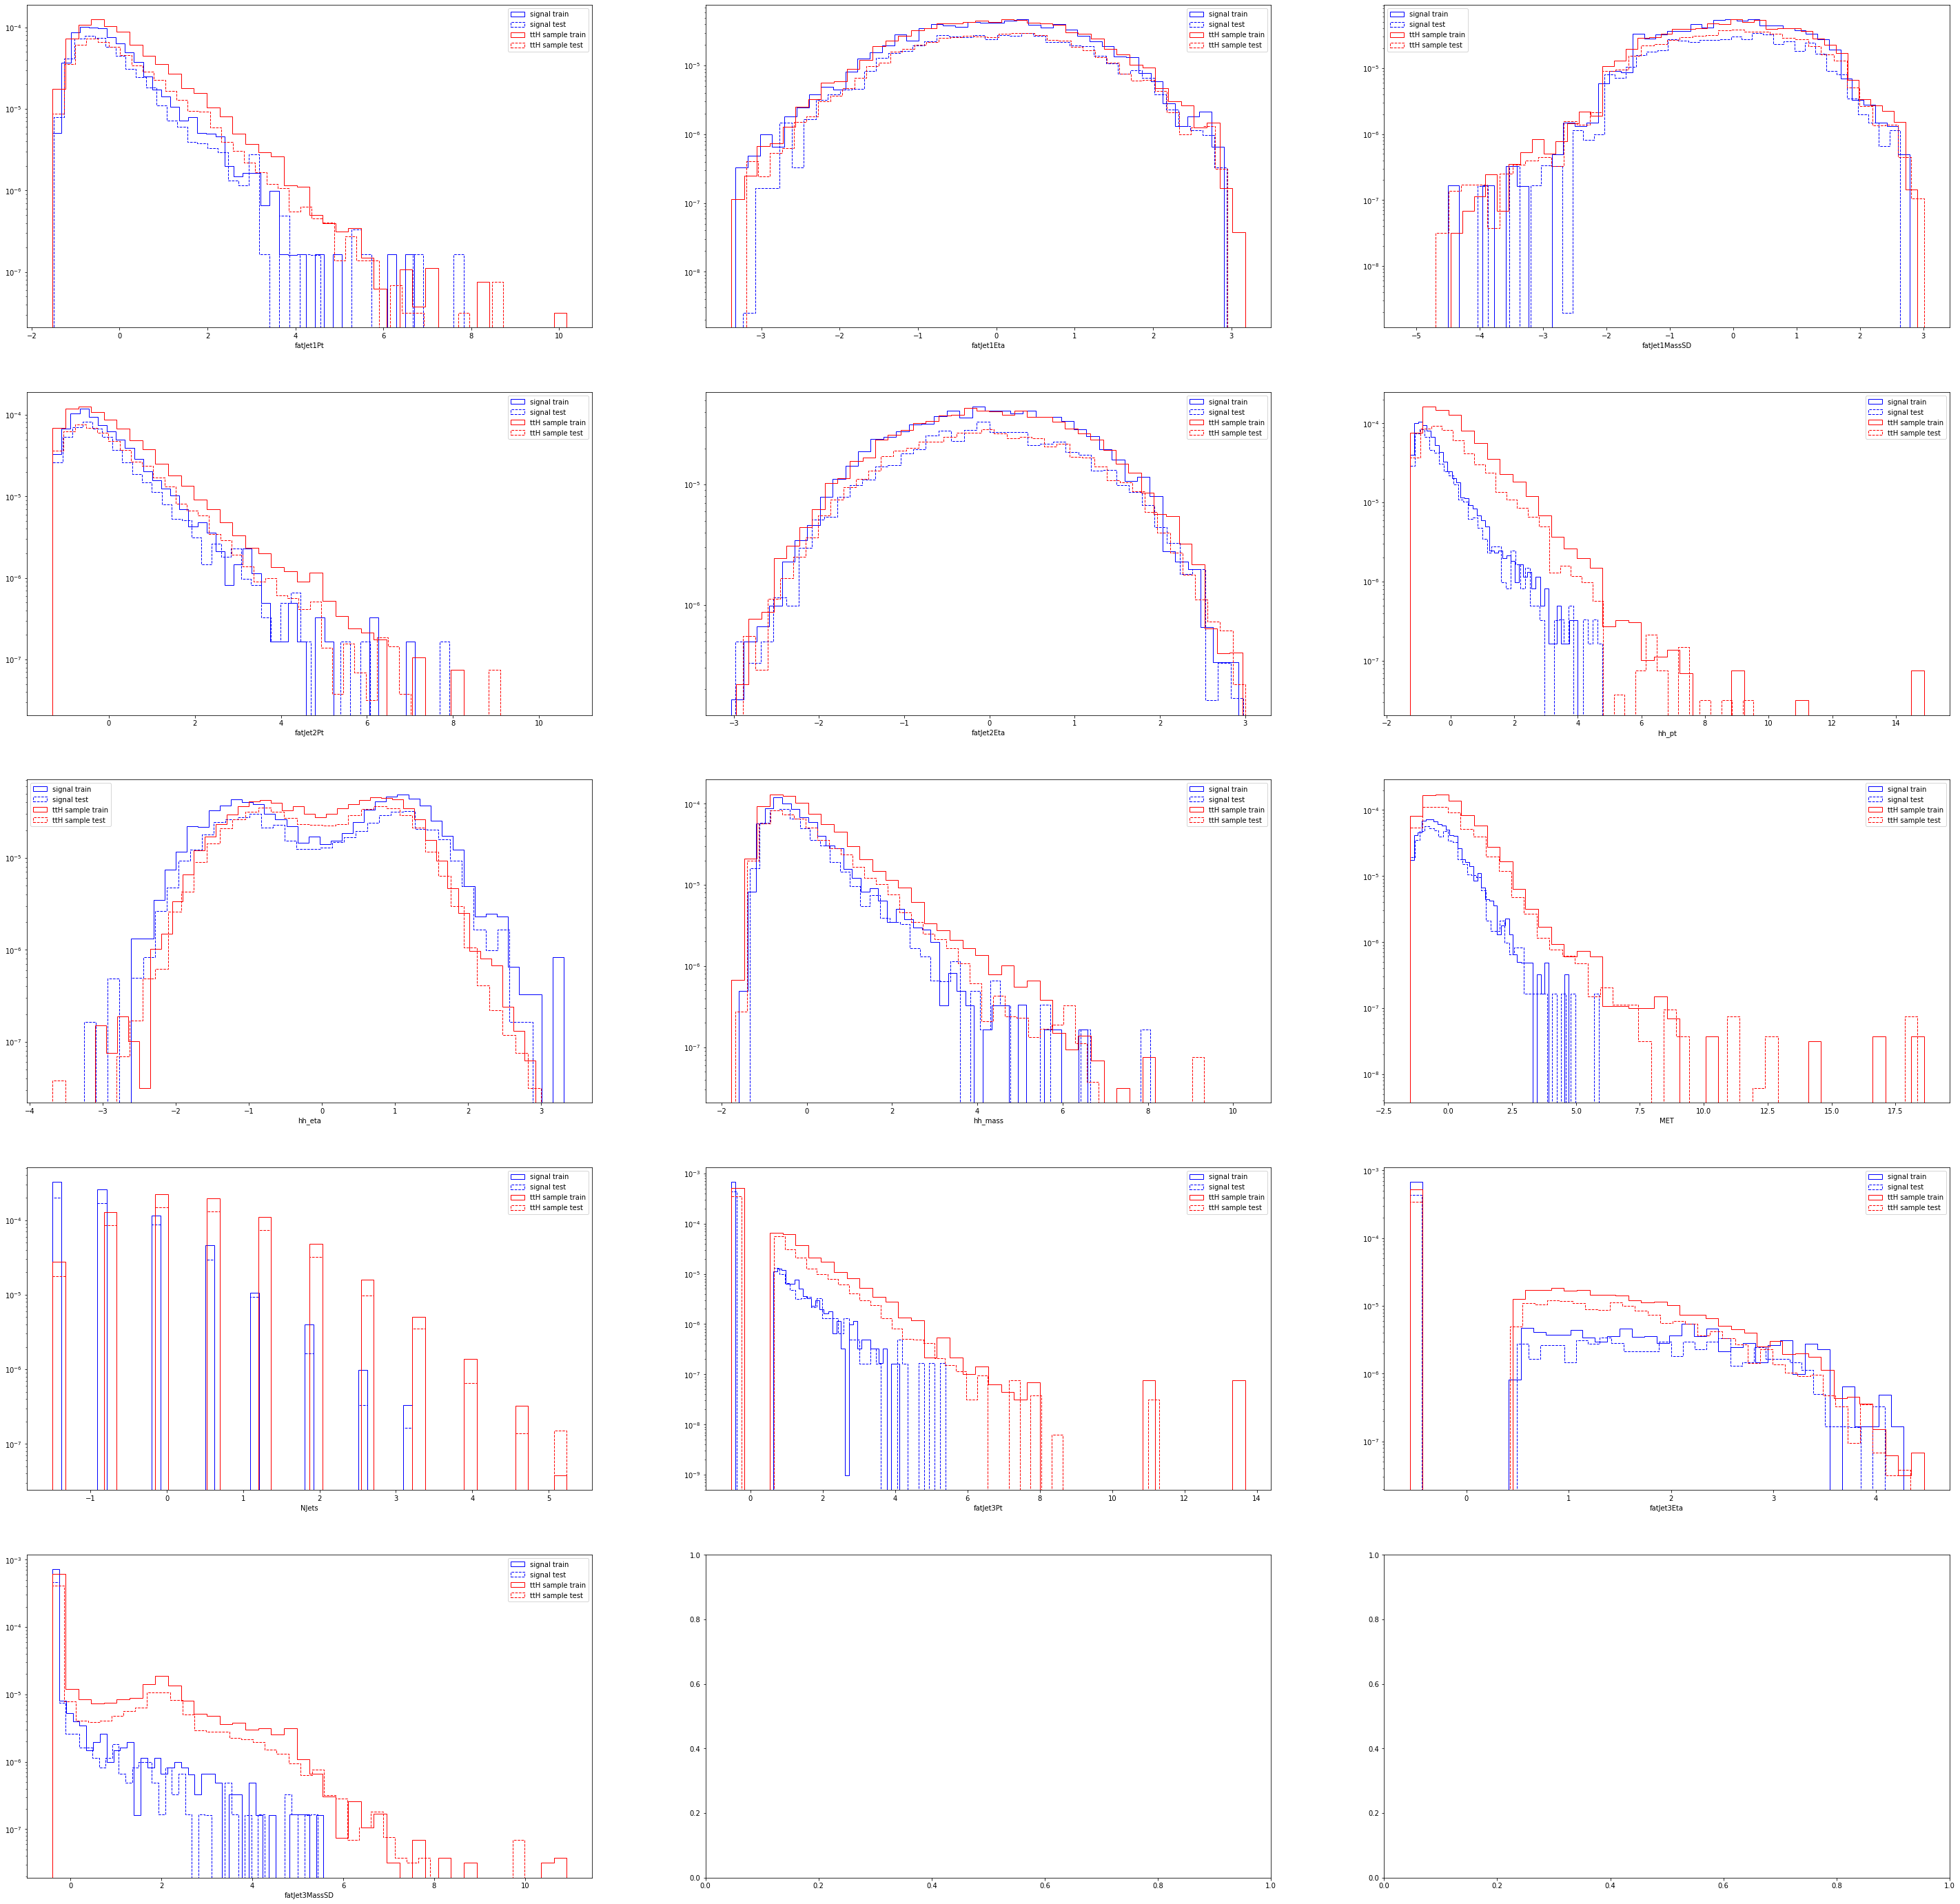

In [17]:
data_id=data[:,id_var_indices]
seed = 10
test_size = 0.4

x_train=data[data_id[:,2]%10 <6]
y_train=label[data_id[:,2]%10 <6]

x_test=data[data_id[:,2]%10 >5]
y_test=label[data_id[:,2]%10 >5]

print(y_test.shape)
is_sig_test = y_test==1
is_bkg_test = y_test==0
print(is_sig_test.shape)
print(mass_var_indices)
z_train= x_train[:,mass_var_indices]
z_test = x_test[:,mass_var_indices]
# For training we ignore the columns with the event ID information

x_mean = np.mean(x_train[:,var_indices],axis=0)
x_std = np.std(x_train[:,var_indices],axis=0)
print(x_mean.shape,x_std.shape)


x_train[:,var_indices] = (x_train[:,var_indices]-x_mean)/x_std
x_test[:,var_indices] = (x_test[:,var_indices]-x_mean)/x_std
x_train_reduced = x_train[:,var_indices]
x_test_reduced = x_test[:,var_indices]
print(x_train_reduced.shape)

x_test_index = x_test[:,id_var_indices]
x_train_index = x_train[:,id_var_indices]

#Re-weight the test events 
x_train_wt = x_train[:,wt_var_indices]
x_test_wt = x_test[:,wt_var_indices]
sig_test_wt=[]
bkg_test_wt_ttH=[] 

for i in range(0,len(x_test_wt)):
    if y_test[i]==1:
        sig_test_wt.append(x_test_wt[i])
        
    if y_test[i]==0:
        bkg_test_wt_ttH.append(x_test_wt[i])

sig_sum = np.sum(sig_test_wt)
ttH_sum = np.sum(bkg_test_wt_ttH)

sig_test_scale = np.sum(signal_wt)/sig_sum
ttH_test_scale = np.sum(bkg_wt_ttH)/ttH_sum

evt_weight=[]
print(np.sum(y_test))
for i in range(0,len(x_test_wt)):
    if(y_test[i]==0):evt_weight.append(x_test_wt[i]*ttH_test_scale)
    elif(y_test[i]==1):evt_weight.append(x_test_wt[i]*sig_test_scale)
  
       
    
print(len(evt_weight))
print(np.sum(evt_weight))

print(x_train_reduced.shape, x_test_reduced.shape)
print(y_train.shape, y_test.shape)
print(y_train.sum(), y_test.sum())

print(x_train_reduced[:,0].shape)


####################################################################################################
##                         Check variables in the train and test samples                          ##
####################################################################################################


f, ax_arr = plt.subplots(5, 3, figsize=(50,50))

i=0
    
for j in range(0,5):
    for k in range(0,3):
        x_train_sig = []
        x_train_bkg =[]
        x_test_sig = []
        x_test_bkg = []
        x_train_sig_wt = []
        x_train_bkg_wt =[]
        x_test_sig_wt = []
        x_test_bkg_wt = []
        temp = x_train_reduced[:,i]
        test_tmp = x_test_reduced[:,i]
      
        for m in range (0,len(y_train)):
            if(y_train[m]==1): 
                x_train_sig.append(temp[m])
                x_train_sig_wt.append(x_train_wt[m])
            else: 
                x_train_bkg.append(temp[m])
                x_train_bkg_wt.append(x_train_wt[m])
        for m in range (0,len(y_test)): 
            if(y_test[m]==1): 
                x_test_sig.append(test_tmp[m])
                x_test_sig_wt.append(x_test_wt[m])
            else:
                x_test_bkg.append(test_tmp[m])   
                x_test_bkg_wt.append(x_test_wt[m])
        x_train_sig = np.array(x_train_sig) 
        x_train_sig_wt = np.array(x_train_sig_wt)
        x_test_sig = np.array(x_test_sig) 
        x_test_sig_wt = np.array(x_test_sig_wt)
        x_train_bkg = np.array(x_train_bkg) 
        x_train_bkg_wt = np.array(x_train_bkg_wt)
        x_test_bkg = np.array(x_test_bkg) 
        x_test_bkg_wt = np.array(x_test_bkg_wt)
        ax_arr[j,k].hist(x_train_sig, bins=40, histtype='step', label='signal train',color='b',weights=x_train_sig_wt)
        ax_arr[j,k].hist(x_test_sig, bins=40, histtype='step', linestyle =('dashed'), label='signal test', color = 'b',weights=x_test_sig_wt)
        ax_arr[j,k].hist(x_train_bkg, bins=40, histtype='step', label='ttH sample train',color='r',weights=x_train_bkg_wt)
        ax_arr[j,k].hist(x_test_bkg, bins=40,  histtype='step', linestyle =('dashed'),color='r',label='ttH sample test',weights=x_test_bkg_wt)
        ax_arr[j,k].set_xlabel(variables[i])
        ax_arr[j,k].legend(prop={'size': 10})
        ax_arr[j,k].legend(loc='best')
        ax_arr[j,k].set_yscale("log")
        i+=1
        if(i ==13): break
    if(i ==13): break
            
plt.show()  

## Fit function that trains a DNN

In [18]:
from scipy import interp
def fit( m_args, f_args):
    
    ###############################################################################################
    ##                                    DNN Classifier                                         ##
    ###############################################################################################
    m = make_model(**m_args)
    h = fit_model(m, x_train_reduced,y_train, x_train_wt.ravel(),**f_args)
    show_losses( [("VBF entropy", h)] )
    ## prediction on train samples

    return m

In [26]:
#m1 = fit({'opt':'adam', 'b_norm': True, 'do': 0.1, 'n_hidden' : 5, 'hidden' : 100},{'batch_size' : 500})
m1 = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=400, verbosity=3, n_jobs=4, gamma=10000000000,num_boost_round=999)
m1.fit(x_train_reduced,y_train,x_train_wt.ravel())
y_pred_train_keras=m1.predict_proba(x_train_reduced)[:,1]
y_pred_keras = m1.predict_proba(x_test_reduced)[:,1]

predictions = [round(value) for value in y_pred_keras]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

AUC = roc_auc_score(y_test, y_pred_keras)
print("AUC: "+str(AUC))

[16:45:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:45:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:45:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:45:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:45:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:45:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:45:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:45:17] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pr

std_wts=[x_mean,x_std]
m1.save('ttHkiller_210920_notau32.h5')
np.save('ttHkiller_210920_wts_notau32.npy',std_wts)

In [29]:
def calc_significance(fpr_keras, tpr_keras, thresholds_keras,y_pred_keras, y_test ,x_test_wt,fpr_val=0.1):
    idx = (np.abs(fpr_keras - fpr_val)).argmin()
    print("tpr at fpr",fpr_val,":", round(tpr_keras[idx],2))
    print("threshold at fpr ",fpr_val,":",round(thresholds_keras[idx],2))
    Nsig = np.sum(x_test_wt[(y_pred_keras>thresholds_keras[idx]) & (y_test==1)])
    Nsig=Nsig*137.1*1000/sig_scale
    tmp=np.square(x_test_wt[(y_pred_keras>thresholds_keras[idx]) & (y_test==1)])
    Nsig_err=np.sum(tmp)
    Nsig_err=math.sqrt(Nsig_err)
    Nsig_err=Nsig_err*137.1*1000/sig_scale
    print("Nsig passing threshold: ", round(Nsig,2), " +/-" , round(Nsig_err,2))
    Nbkg =  np.sum(x_test_wt[(y_pred_keras>thresholds_keras[idx]) & (y_test==0)])
    tmp=np.square(x_test_wt[(y_pred_keras>thresholds_keras[idx]) & (y_test==0)])
    Nbkg_err=np.sum(tmp)
    Nbkg_err=math.sqrt(Nbkg_err)
    Nbkg=Nbkg*137.1*1000
    Nbkg_err=Nbkg_err*137.1*1000
    print("Nbkg passing threshold: ",round(Nbkg,2), " +/-" , round(Nbkg_err,2))
    #print("L :", math.sqrt(2*((Nsig+Nbkg)*np.log(1+(Nsig/Nbkg))-Nsig)))
    print("Nsig/sqrt(Nsig+Nbkg):", round(Nsig/math.sqrt(Nsig+Nbkg),2))

## Calculate significance

===============================[110.,150.]=============================================== GeV
[0.50036263 0.50036263 0.50036263 ... 0.50036263 0.50036263 0.50036263]
1 1.0 1.0 0.50036263


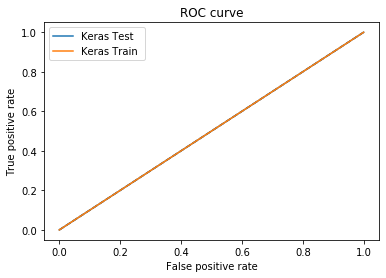

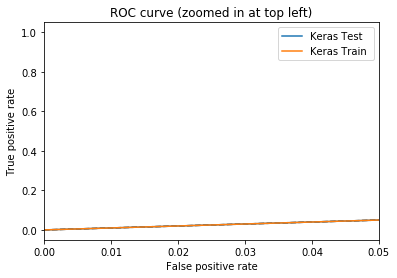

========================================Caltech===========================
tpr at fpr 0.1 : 0.0
threshold at fpr  0.1 : 1.5
Nsig passing threshold:  0.0  +/- 0.0
Nbkg passing threshold:  0.0  +/- 0.0
Nsig/sqrt(Nsig+Nbkg): nan
tpr at fpr 0.01 : 0.0
threshold at fpr  0.01 : 1.5
Nsig passing threshold:  0.0  +/- 0.0
Nbkg passing threshold:  0.0  +/- 0.0
Nsig/sqrt(Nsig+Nbkg): nan
tpr at fpr 0.001 : 0.0
threshold at fpr  0.001 : 1.5
Nsig passing threshold:  0.0  +/- 0.0
Nbkg passing threshold:  0.0  +/- 0.0
Nsig/sqrt(Nsig+Nbkg): nan


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


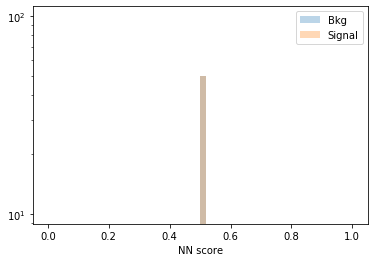

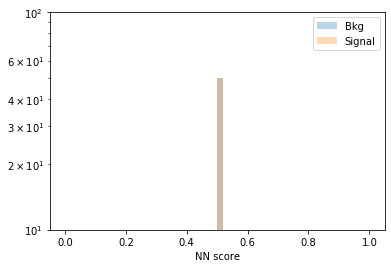

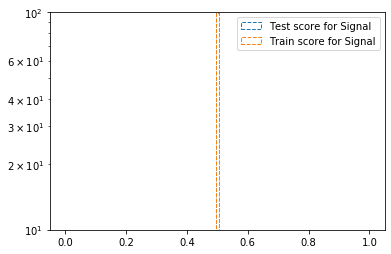

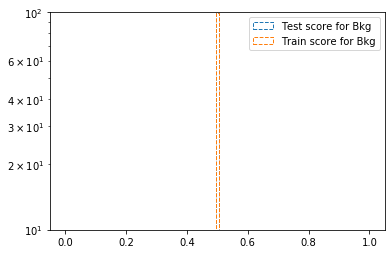

===============================[124.5.,125.5] GeV============================================
========================================Caltech===========================
tpr at fpr 0.1 : 0.1
threshold at fpr  0.1 : 1.4
Nsig passing threshold:  0.0  +/- 0.0
Nbkg passing threshold:  0.0  +/- 0.0
Nsig/sqrt(Nsig+Nbkg): nan
tpr at fpr 0.01 : 0.01
threshold at fpr  0.01 : 1.49
Nsig passing threshold:  0.0  +/- 0.0
Nbkg passing threshold:  0.0  +/- 0.0
Nsig/sqrt(Nsig+Nbkg): nan


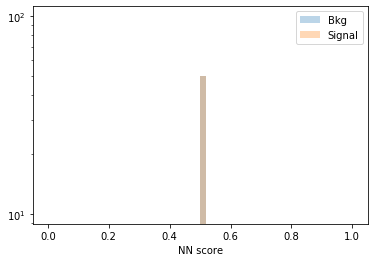

===========================================[120.,130.]=========================================== GeV
========================================Caltech===========================
tpr at fpr 0.1 : 0.0
threshold at fpr  0.1 : 1.5
Nsig passing threshold:  0.0  +/- 0.0
Nbkg passing threshold:  0.0  +/- 0.0
Nsig/sqrt(Nsig+Nbkg): nan
tpr at fpr 0.01 : 0.0
threshold at fpr  0.01 : 1.5
Nsig passing threshold:  0.0  +/- 0.0
Nbkg passing threshold:  0.0  +/- 0.0
Nsig/sqrt(Nsig+Nbkg): nan


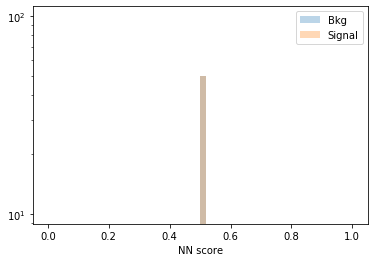

In [31]:
evt_weight=np.array(evt_weight)
print("===============================[110.,150.]=============================================== GeV")
print(y_pred_train_keras)
fpr_keras_tmp, tpr_keras_tmp, thresholds_keras_tmp = roc_curve(y_train, y_pred_train_keras,sample_weight=x_train_wt)
# predict on test samples
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras,sample_weight=x_test_wt)
abs_array = np.abs(tpr_keras-0.90)
idx = np.argmin(abs_array)
print(idx, tpr_keras[idx], fpr_keras[idx],thresholds_keras[idx])
DNN_ROC(fpr_keras,tpr_keras,fpr_keras_tmp,tpr_keras_tmp) 
#
print("========================================Caltech===========================")
calc_significance(fpr_keras, tpr_keras, thresholds_keras,y_pred_keras, y_test,evt_weight, 0.1)
calc_significance(fpr_keras, tpr_keras, thresholds_keras,y_pred_keras, y_test,evt_weight, 0.01)
calc_significance(fpr_keras, tpr_keras, thresholds_keras,y_pred_keras, y_test,evt_weight, 0.001)
  
w2 = (z_train>120.) & (z_train<130.)
w2_t = (z_test>120.) & (z_test<130.)
w1 = (z_train>124.5) & (z_train<125.5)
w1_t = (z_test>124.5) & (z_test<125.5)


score_classifier(y_test,y_pred_keras,'NN score')
score_classifier(y_train,y_pred_train_keras,'NN score')
plt.figure(1)
plt.hist(y_pred_keras[y_test==1],bins=np.linspace(0.,1.,100), histtype='step', density=True,linestyle =('dashed'), label='Test score for Signal')
plt.hist(y_pred_train_keras[y_train==1],bins=np.linspace(0.,1.,100), histtype='step', density=True,linestyle =('dashed'), label='Train score for Signal')
plt.yscale('log')
plt.legend(loc='best')
plt.show()


plt.figure(2)
plt.hist(y_pred_keras[y_test==0],bins=np.linspace(0.,1.,100), histtype='step', density=True,linestyle =('dashed'), label='Test score for Bkg')
plt.hist(y_pred_train_keras[y_train==0],bins=np.linspace(0.,1.,100), histtype='step', density=True,linestyle =('dashed'), label='Train score for Bkg')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

print("===============================[124.5.,125.5] GeV============================================")

y_pred_keras_w1 = y_pred_keras[w1_t[:,0]]
y_test_w1 = y_test[w1_t[:,0]]
x_test_wt_w1 = evt_weight[w1_t[:,0]]
#print(y_pred_keras_w1.shape,y_test_w1.shape,x_test_wt_w1.shape)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_w1, y_pred_keras_w1,sample_weight=x_test_wt_w1)



mean_fpr = np.linspace(0., 1., 100)
tprs = interp(mean_fpr, fpr_keras, tpr_keras)
ths= interp(mean_fpr, fpr_keras, thresholds_keras)



print("========================================Caltech===========================")
calc_significance(mean_fpr, tprs, ths,y_pred_keras_w1, y_test_w1,x_test_wt_w1, 0.1)
calc_significance(mean_fpr, tprs, ths,y_pred_keras_w1, y_test_w1,x_test_wt_w1, 0.01)

score_classifier(y_test_w1,y_pred_keras_w1,'NN score')


print("===========================================[120.,130.]=========================================== GeV")
y_pred_keras_w2 = y_pred_keras[w2_t[:,0]]
y_test_w2 = y_test[w2_t[:,0]]
x_test_wt_w2 = evt_weight[w2_t[:,0]]
print("========================================Caltech===========================")

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_w2, y_pred_keras_w2,sample_weight=x_test_wt_w2)
calc_significance(fpr_keras, tpr_keras, thresholds_keras,y_pred_keras_w2, y_test_w2, x_test_wt_w2,0.1)
calc_significance(fpr_keras, tpr_keras, thresholds_keras,y_pred_keras_w2, y_test_w2,x_test_wt_w2, 0.01)

score_classifier(y_test_w2,y_pred_keras_w2,'NN score')


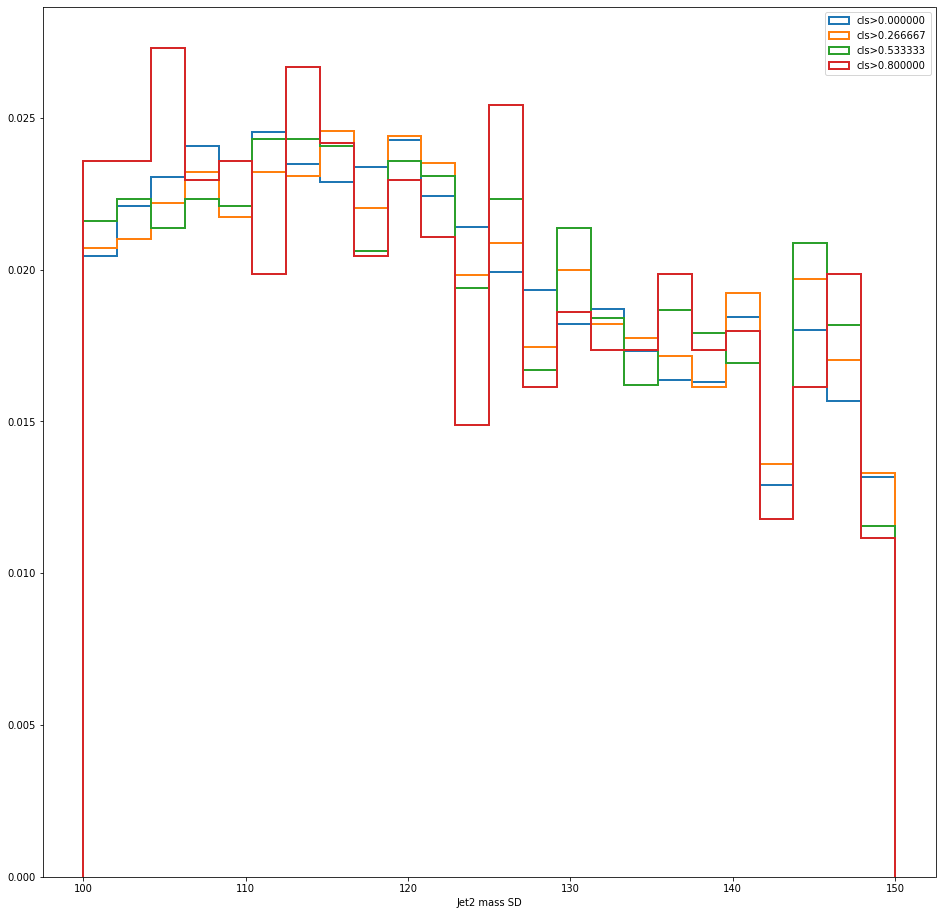

In [23]:
from scipy import interp
from scipy.stats import wasserstein_distance
def cls_sculptor(pred_simple_cls):
    

    plt.figure(figsize=(2*8,2*8))
   
    bins = np.linspace(100., 150., 25)
    mass_shapes=[]
    for icut in np.linspace(0.0, 0.8, 4):
        cut = pred_simple_cls[:] > icut
        mass_shapes.append(z_test[np.invert(is_sig_test) & cut, 0])
        plt.hist(z_test[np.invert(is_sig_test) & cut, 0], bins=bins, density=1.0, lw=2.0, histtype="step", label="cls>{0:2f}".format(icut));
    plt.legend(fontsize=6, frameon=False)
    #plt.yscale("log")
    plt.xlabel("Jet2 mass SD")
    #print "Simple Classifier"
    # Kolmogorov Test, arrays should be in ascending order
   
    
    plt.legend(loc='best')
    
    plt.show()

cls_sculptor(y_pred_keras)
    

In [24]:
def make_cls_model(inp_shape, b_norm = False, n_hidden = 1, hidden= 100, do = 0.2):
    i = inp_shape
    di = i
    for h in range(n_hidden):
        d = Dense(hidden, name='hidden_%d'%h, activation='tanh')(di)
        if do:
            d = Dropout(do)(d)
        if b_norm:
            d = BatchNormalization()(d)
        di = d
    o = Dense(1, name='categorization', activation='sigmoid')(d)
    model = Model(i,o,name='classifier')
    #model.summary()
    return model

In [25]:
def fit_cls_model(model,x_train_reduced,y_train, x_train_wt,batch_size = 20, val_split=0.2):
    hist = model.fit(x_train_reduced, y_train, sample_weight= x_train_wt,batch_size=batch_size, nb_epoch=500,verbose=0,validation_split=val_split,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')])
    return hist

In [26]:
def train_model(varlist):

    hists = []

    x_train_reduced_smaller = x_train_reduced[:, varlist]
    x_test_reduced_smaller = x_test_reduced[:, varlist]

    m_best = make_cls_model(Input((x_train_reduced_smaller.shape[1],), name='features'), True, 5, 100, 0.1)
    m_best.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    h = fit_cls_model(m_best, x_train_reduced_smaller,y_train, x_train_wt.ravel(),500)
    
    y_pred = m_best.predict(x_test_reduced_smaller, batch_size=500).ravel()
    #output_file(y_pred)
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
    auc_keras = auc(fpr_keras, tpr_keras)

#     y_pred_bkg = y_pred[y_test==0]
#     y_pred_sig = y_pred[y_test==1]
#     plt.hist(y_pred_sig,bins=np.linspace(0,1,100), density=1.0, lw=2.0, histtype="step",label ='signal')
#     plt.hist(y_pred_bkg,bins=np.linspace(0,1,100), density=1.0, lw=2.0, histtype="step",label='bkg')
#     plt.legend()
#     plt.show()
    
#     fpr_keras_tmp, tpr_keras_tmp, thresholds_keras_tmp = roc_curve(y_test,y_pred)
#     auc_keras = auc(fpr_keras, tpr_keras)
    
#     plt.plot(fpr_keras_tmp, tpr_keras_tmp, label='Keras Test (area = {:.3f})'.format(auc_keras))
#     #plt.xlim(0,0.02)
#     #plt.ylim(0.8,1.0)
#     plt.xlabel("False positive rate")
#     plt.ylabel('True positive rate')
#     plt.title('ROC curve')
#     plt.legend(loc='best')
#     plt.show()  

    return fpr_keras, tpr_keras
    #hists.append(h)
    #show_losses( [("VBF entropy", h)] )

In [27]:
rocs = []

for nvars in [1,2,5,10,12,13]:
    print(nvars)
    rocs += [train_model(range(nvars))]

1


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00011: early stopping
2


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00008: early stopping
5


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00083: early stopping
10


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00121: early stopping
12


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00164: early stopping
13


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00210: early stopping


Text(0, 0.5, 'tpr')

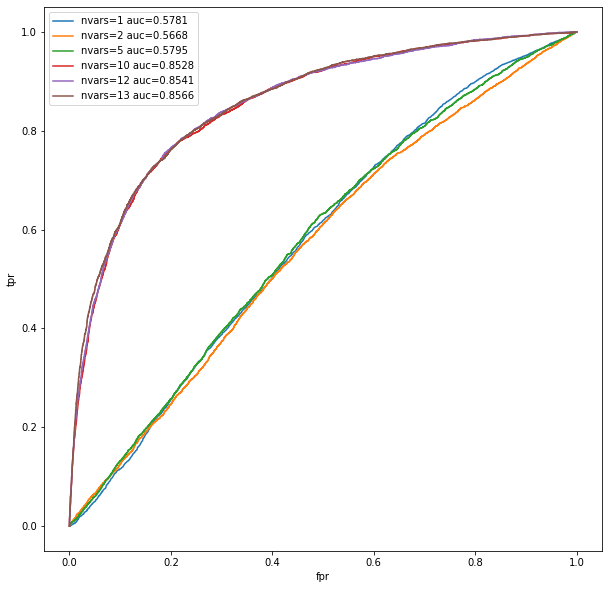

In [28]:
nvars = [1,2,5,10,12,13]
plt.figure(figsize=(10, 10))
for (fpr, tpr), nvar in zip(rocs, nvars):
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="nvars={0} auc={1:.4f}".format(nvar, auc_val))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")

Text(0, 0.5, 'tpr')

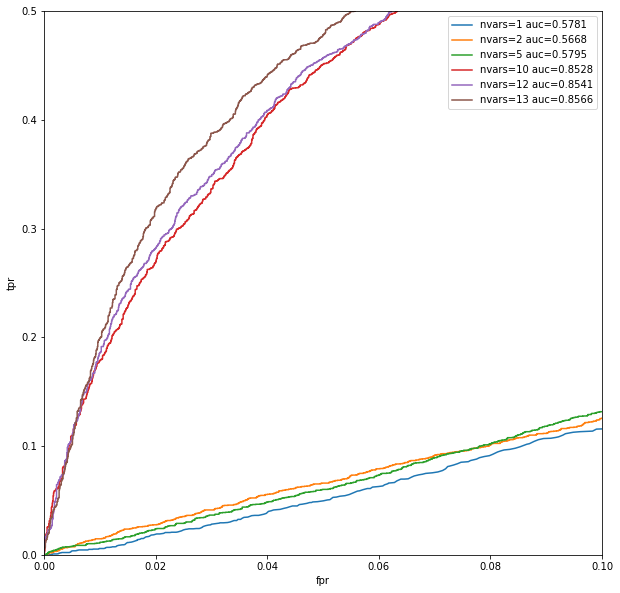

In [29]:
nvars = [1,2,5,10,12,13]
plt.figure(figsize=(10, 10))
for (fpr, tpr), nvar in zip(rocs, nvars):
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="nvars={0} auc={1:.4f}".format(nvar, auc_val))
    plt.xlim(0,0.1)
    plt.ylim(0.0,0.5)
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")

In [30]:
def train_model_new(varlist):

    
    #print varlist
    x_train_reduced_smaller = x_train_reduced[:, varlist]
    x_test_reduced_smaller = x_test_reduced[:, varlist]

    m_best = make_cls_model(Input((x_train_reduced_smaller.shape[1],),name = 'features'), True, 5, 100, 0.1)
    m_best.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    h = fit_cls_model(m_best, x_train_reduced_smaller,y_train, x_train_wt.ravel(),500)
    m_best.save("test_simpleDNN.h5")
    y_pred = m_best.predict(x_test_reduced_smaller, batch_size=500).ravel()
    #print y_pred, y_test
    
    #print x_test_reduced_smaller.shape, x_test_wt.shape
    sig_test_wt=[]
    bkg_test_wt_ttH=[] 

    for i in range(0,len(x_test_wt)):
        if y_test[i]==1:
            sig_test_wt.append(x_test_wt[i])

        if y_test[i]==0:
            bkg_test_wt_ttH.append(x_test_wt[i])

    sig_sum = np.sum(sig_test_wt)
    ttH_sum = np.sum(bkg_test_wt_ttH)

    sig_test_scale = np.sum(signal_wt)/sig_sum
    ttH_test_scale = np.sum(bkg_wt_ttH)/ttH_sum

    evt_weight=[]
    print(np.sum(y_test))
    for i in range(0,len(x_test_wt)):
        if(y_test[i]==0):evt_weight.append(x_test_wt[i]*ttH_test_scale)
        elif(y_test[i]==1):evt_weight.append(x_test_wt[i]*sig_test_scale)


    evt_weight = np.array(evt_weight)
    #print evt_weight.shape
    #print np.sum(evt_weight)

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)#,evt_weight.ravel())
    auc_keras = auc(fpr_keras, tpr_keras)

    
    return fpr_keras, tpr_keras

In [31]:
rocs_new=[]
for k in range(0,13):
    varlist = [i for i in range(0,13) if i != k]
    print(len(varlist))
    rocs_new += [train_model_new(varlist)]

12


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00161: early stopping
3806.0
12


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00171: early stopping
3806.0
12


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00021: early stopping
3806.0
12


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00154: early stopping
3806.0
12


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00179: early stopping
3806.0
12


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00125: early stopping
3806.0
12


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00127: early stopping
3806.0
12


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00112: early stopping
3806.0
12


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00156: early stopping
3806.0
12


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00179: early stopping
3806.0
12


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00114: early stopping
3806.0
12


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00119: early stopping
3806.0
12


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 00160: early stopping
3806.0


Text(0, 0.5, 'tpr')

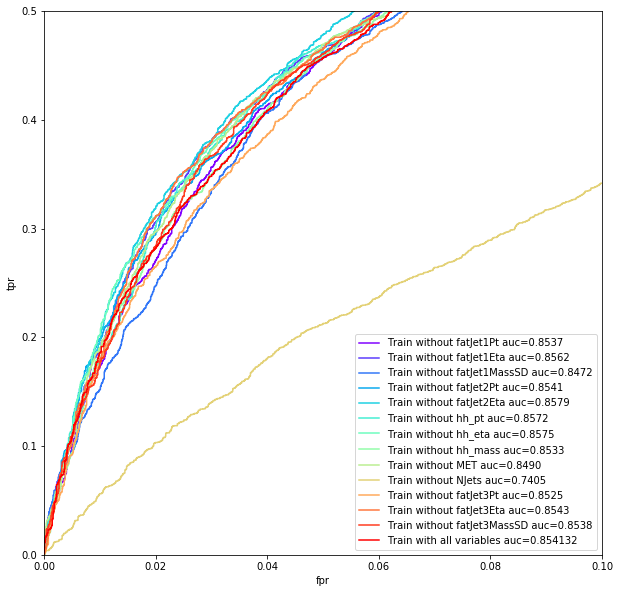

In [33]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 14))
plt.figure(figsize=(10, 10))
#for (fpr, tpr,sens1,sens2,sens3), hlf,c  in zip(rocs_new, HLF,colors):
for (fpr, tpr), hlf,c  in zip(rocs_new,variables,colors):
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="Train without {0} auc={1:.4f}".format(hlf, auc_val),color = c)
    plt.xlim(0,0.1)
    plt.ylim(0.,0.5)
fpr_full,tpr_full = rocs[4]
auc_val = auc(fpr_full, tpr_full)
plt.plot(fpr_full, tpr_full, label="Train with all variables auc={0:4f}".format( auc_val), color = colors[13])
#plt.xlim(0,0.01)
#plt.ylim(0.9,1)
plt.legend(loc='best')
plt.xlabel("fpr")
plt.ylabel("tpr")

In [34]:
tpr_all=[]
sens_all=[]
for (fpr, tpr), hlf  in zip(rocs_new, variables):
    auc_val = auc(fpr, tpr)
    tpr_all.append(tpr[np.abs(fpr-0.01).argmin()])
    sens_all.append(auc_val)
hlf_index=np.argsort(sens_all)
for k in hlf_index:
    print(variables[k])

NJets
fatJet1MassSD
MET
fatJet3Pt
hh_mass
fatJet1Pt
fatJet3MassSD
fatJet2Pt
fatJet3Eta
fatJet1Eta
hh_pt
hh_eta
fatJet2Eta
